In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib as mpl
import math
import pickle
import matplotlib.patches as mpatches
from tqdm import tqdm
from scipy import stats


dat_path = os.getcwd()[:-12] + 'Data/'
fig_path = os.getcwd()[:-4] + 'figures/preliminary/'
generated_dat_path = os.getcwd()[:-12] + 'Data/generated_data/'

text_font = 30

In [2]:
min_career = 25
norm_quant = 'Runs'
odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

odi_final.columns

Index(['search_ID', 'Match_ID', 'Match_Date', 'Venue', 'Team', 'Overs', 'Runs',
       'Wickets', 'player_name', 'bat_pos', 'bat_run', 'bat_balls',
       'bat_fours', 'bat_sixes', 'bat_wicket', 'bowl_overs', 'bowl_maiden',
       'bowl_runs', 'bowl_wickets', 'captain', 'wicketkeeper', 'PoM', 'Winner',
       'Batting_Order', 'renormalized_bat_run', 'renormalized_runs',
       'renormalized_bowl_runs', 'team_match_num', 'batsmen', 'bowler',
       'allrounder', 'opp_wickets'],
      dtype='object')

In [3]:
def axis_decor(ax, text_font, major_length, minor_length, linewidth):

    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)

    ax.tick_params(axis='both', which='major', labelsize=text_font, length=major_length, width=linewidth)
    ax.tick_params(axis='both', which='minor', labelsize=text_font, length=minor_length, width=linewidth)

In [4]:
def early_career_data(min_career, norm_quant, early_epoch):

    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')
    player_name_list = odi_final['player_name'].unique()

    early_bat, full_bat = [], []
    early_bowl, full_bowl = [], []


    for player_name in tqdm(player_name_list):
        temp_player_df = odi_final[odi_final['player_name'] == player_name]
        temp_player_df = temp_player_df.sort_values(by='Match_ID')

        if len(temp_player_df['Match_ID'].unique()) >= early_epoch*2:

            if temp_player_df['batsmen'].sum() > min_career:
                early_runs_mean = temp_player_df.iloc[:early_epoch]['renormalized_bat_run'].dropna().mean()
                tot_runs_mean = temp_player_df['bat_run'].dropna().mean()

                if tot_runs_mean > early_epoch*0.25:
                    early_bat.append(early_runs_mean)
                    full_bat.append(tot_runs_mean)

            if temp_player_df['bowler'].sum() > min_career:
                early_wickets_mean = temp_player_df.iloc[:early_epoch]['bowl_wickets'].dropna().mean()
                tot_wickets_mean = temp_player_df['bowl_wickets'].dropna().mean()

                if tot_wickets_mean > early_epoch*0.00625:
                    early_bowl.append(early_wickets_mean)
                    full_bowl.append(tot_wickets_mean)

    with open(generated_dat_path + f'early_and_late_career_performance_min_career_{min_career}_early_{early_epoch}.pkl', 'wb') as f:
        pickle.dump([early_bat, full_bat, early_bowl, full_bowl], f)

# early_career_data(min_career=25, norm_quant='Runs', early_epoch=25)

bat =  0.5702702702702702


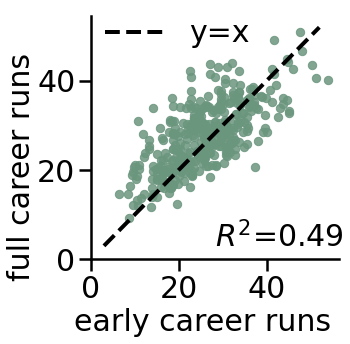

bowl =  0.4537313432835821


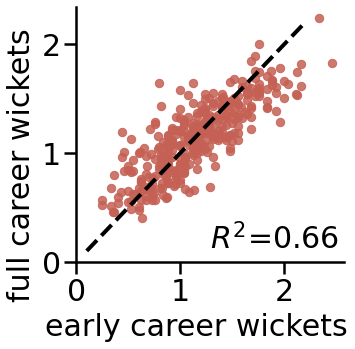

In [9]:
def early_career_plot(early_dat, late_dat, category, color):

    fig, ax = plt.subplots(1,1, figsize=(5,5))

    early_dat = np.array(early_dat)
    late_dat = np.array(late_dat)

    ind = np.where(early_dat>0)[0]
    ax.scatter(early_dat[ind], late_dat[ind], color=color, s=70, alpha=0.85)
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(early_dat[ind], late_dat[ind])
    r_squared = r_value**2

    # Display R-squared value as text in the plot
    ax.text(0.5, 0.05, rf'$R^2$={r_squared:.2f}', transform=ax.transAxes, fontsize=text_font)

    print(f'{category} = ', np.count_nonzero(early_dat[ind] < late_dat[ind])/len(late_dat[ind]))

    

    if category == 'bat':
        ax.set_xticks([0, 20, 40], fontsize=text_font)
        ax.set_yticks([0, 20, 40], fontsize=text_font)

        x_dat = np.linspace(3, 52, 100)
        ax.plot(x_dat, x_dat, '--', color='black', linewidth=4, label='y=x')

        ax.set_xlabel(rf'early career runs',fontsize=text_font)
        ax.set_ylabel(rf'full career runs', fontsize=text_font)

        ax.xaxis.set_label_coords(0.45, -0.2)
        ax.yaxis.set_label_coords(-0.22, 0.38)

        plt.ylim(bottom=0)
        plt.xlim(left=0)

        ax.legend(fontsize=text_font, loc='upper left', frameon=False, bbox_to_anchor=(-0.05, 0.9, 0.2, 0.2), labelspacing=0.1)
    
    elif category == 'bowl':
        ax.set_xticks([0, 1, 2], fontsize=text_font)
        ax.set_yticks([0, 1, 2], fontsize=text_font)

        x_dat = np.linspace(0.1, 2.2, 100)
        ax.plot(x_dat, x_dat, '--', color='black', linewidth=4)
        
        ax.set_xlabel(rf'early career wickets',fontsize=text_font)
        ax.set_ylabel(rf'full career wickets', fontsize=text_font)

        #shift x and y axis labels
        ax.xaxis.set_label_coords(0.45, -0.2)
        ax.yaxis.set_label_coords(-0.15, 0.38)

        plt.ylim(bottom=0)
        plt.xlim(left=0)

    axis_decor(ax, text_font, 12, 5, 2.5)
    

    plt.tight_layout()
    plt.savefig(fig_path + f'{category}_early_and_late_career_performance_min_career_{min_career}_early_{early_epoch}.pdf', format='pdf', dpi=300)
    plt.savefig(fig_path + f'{category}_early_and_late_career_performance_min_career_{min_career}_early_{early_epoch}.jpeg', format='jpeg', dpi=300)
    plt.show()
    plt.close()


early_epoch = 25
min_career = 25
with open(generated_dat_path + f'early_and_late_career_performance_min_career_{min_career}_early_{early_epoch}.pkl', 'rb') as f:
    early_bat, late_bat, early_bowl, late_bowl = pickle.load(f)

early_career_plot(early_bat, late_bat, 'bat', '#6B967E')
early_career_plot(early_bowl, late_bowl, 'bowl', '#C56054')

In [6]:
def drop_reentry_data(min_career, norm_quant, history, min_drop_length):

    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

    odi_final['Match_Date'] = pd.to_datetime(odi_final['Match_Date'])

    odi_final = odi_final.sort_values(by=['Match_ID','Team'])

    players_list = np.unique(odi_final['player_name'])

    before_bat, after_bat = [[] for x in range(history)], [[] for x in range(history)]
    before_bowl, after_bowl = [[] for x in range(history)], [[] for x in range(history)]

    for player in tqdm(players_list):

        player_df = odi_final[odi_final['player_name'] == player]

        player_match_num = player_df['team_match_num'].values

        if player_df['batsmen'].sum() > min_career:
                
            for i in range(history,len(player_match_num)-history):
                    
                if (player_df.iloc[i, player_df.columns.get_loc('team_match_num')]) - (player_df.iloc[i-1, player_df.columns.get_loc('team_match_num')]) > min_drop_length:
                        
                    for h in range(history):
                        before_bat[h].append(player_df.iloc[i-h-1, player_df.columns.get_loc('renormalized_bat_run')])
                        after_bat[h].append(player_df.iloc[i+h, player_df.columns.get_loc('renormalized_bat_run')])


        if player_df['bowler'].sum() > min_career:

            for i in range(history,len(player_match_num)-history):
            
                if (player_df.iloc[i, player_df.columns.get_loc('team_match_num')]) - (player_df.iloc[i-1, player_df.columns.get_loc('team_match_num')]) > min_drop_length:
                        
                    for h in range(history):
                        before_bowl[h].append(player_df.iloc[i-h-1, player_df.columns.get_loc('bowl_wickets')])
                        after_bowl[h].append(player_df.iloc[i+h, player_df.columns.get_loc('bowl_wickets')])


    with open(generated_dat_path + f'drop_reentry_min_career_{min_career}_renorm_{norm_quant}_history_{history}_min_drop_length_{min_drop_length}.pkl', 'wb') as f:
        pickle.dump([before_bat, after_bat, before_bowl, after_bowl], f)

# drop_reentry_data(min_career=25, norm_quant='Runs', history=5, min_drop_length=3)

In [7]:
def drop_reentry_plot(min_career, norm_quant, history, min_drop_length, category, color):

    with open(generated_dat_path + f'drop_reentry_min_career_{min_career}_renorm_{norm_quant}_history_{history}_min_drop_length_{min_drop_length}.pkl', 'rb') as f:
        before_bat, after_bat, before_bowl, after_bowl = pickle.load(f)

    fig, ax = plt.subplots(1,1,figsize=(10, 5))

    if category == 'bat':

        before_bat_dat = [np.nanmean(before_bat[i]) for i in range(history)]
        after_bat_dat = [np.nanmean(after_bat[i]) for i in range(history)]

        before_bat_err = [np.nanstd(before_bat[i])/np.sqrt(len(before_bat[i])) for i in range(history)]
        after_bat_err = [np.nanstd(after_bat[i])/np.sqrt(len(after_bat[i])) for i in range(history)]

        print((before_bat_dat[-1] - before_bat_dat[0])/before_bat_dat[-1])
        print((before_bat_dat[0]-after_bat_dat[0])/before_bat_dat[0])

        ax.errorbar(np.arange(history), before_bat_dat[::-1], yerr=before_bat_err[::-1], color=color, linewidth=3, marker='o', markersize=10, label='batting')
        ax.errorbar(history+1 + np.arange(history), after_bat_dat, yerr=after_bat_err, color=color, linewidth=3, marker='o', markersize=10)

        ax.add_line(mpl.lines.Line2D([history-1, history+1], [before_bat_dat[0], after_bat_dat[0]], color=color, linewidth=3, linestyle='--'))
        ax.set_ylabel('runs', fontsize=text_font)
        ax.text(0, 21.5, 'before', fontsize=text_font+5, color=color, fontweight='bold')
        ax.text(7, 26, 'after', fontsize=text_font+5, color=color, fontweight='bold')
        ax.set_yticks([20, 24, 28], fontsize=text_font)

    elif category == 'bowl':

        before_bowl_dat = [np.nanmean(before_bowl[i]) for i in range(history)]
        after_bowl_dat = [np.nanmean(after_bowl[i]) for i in range(history)]

        before_bowl_err = [np.nanstd(before_bowl[i])/np.sqrt(len(before_bowl[i])) for i in range(history)]
        after_bowl_err = [np.nanstd(after_bowl[i])/np.sqrt(len(after_bowl[i])) for i in range(history)]

        print((before_bowl_dat[-1] - before_bowl_dat[0])/before_bowl_dat[-1])
        print((before_bowl_dat[0]-after_bowl_dat[0])/before_bowl_dat[0])

        ax.errorbar(np.arange(history), before_bowl_dat[::-1], yerr=before_bowl_err[::-1], color=color, linewidth=3, marker='o', markersize=10, label='bowling')
        ax.errorbar(history +1 + np.arange(history), after_bowl_dat, yerr=after_bowl_err, color=color, linewidth=3, marker='o', markersize=10)

        ax.add_line(mpl.lines.Line2D([history-1, history+1], [before_bowl_dat[0], after_bowl_dat[0]], color=color, linewidth=3, linestyle='--'))
        ax.set_ylabel('wickets', fontsize=text_font)
        ax.text(0, 0.98, 'before', fontsize=text_font+5, color=color, fontweight='bold')
        ax.text(7, 1.08, 'after', fontsize=text_font+5, color=color, fontweight='bold')


    ax.set_xlabel('match number', fontsize=text_font)
    ax.set_xticks([0,1,2,3,4,6,7,8,9,10], [5,4,3,2,1, 1,2,3,4,5])
    axis_decor(ax, text_font, 10, 5, 3)

    plt.tight_layout()
    plt.savefig(fig_path + f'drop_reentry_min_career_{min_career}_renorm_{norm_quant}_history_{history}_min_drop_length_{min_drop_length}_{category}.pdf', format='pdf', dpi=300)
    plt.show()
    plt.close()


# drop_reentry_plot(min_career=25, norm_quant='Runs', history=5, min_drop_length=3, category='bat', color='#11808D')
# drop_reentry_plot(min_career=25, norm_quant='Runs', history=5, min_drop_length=3, category='bowl', color='#6B4A63')

In [8]:
def individual_early(min_career, norm_quant, early_epoch):

    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')
    player_name_list = ['Ricky Ponting', 'Shane Warne']


    for player_name in tqdm(player_name_list):
        temp_player_df = odi_final[odi_final['player_name'] == player_name]
        temp_player_df = temp_player_df.sort_values(by='Match_ID')

        if len(temp_player_df['Match_ID'].unique()) >= early_epoch*2:

            if temp_player_df['batsmen'].sum() > min_career:
                early_runs_mean = temp_player_df.iloc[:early_epoch]['renormalized_bat_run'].dropna().mean()
                tot_runs_mean = temp_player_df['bat_run'].dropna().mean()

                if tot_runs_mean > early_epoch*0.25:
                    print(player_name, early_runs_mean, tot_runs_mean)

            if temp_player_df['bowler'].sum() > min_career:
                early_wickets_mean = temp_player_df.iloc[:early_epoch]['bowl_wickets'].dropna().mean()
                tot_wickets_mean = temp_player_df['bowl_wickets'].dropna().mean()

                if tot_wickets_mean > early_epoch*0.00625:
                    print(player_name, early_wickets_mean, tot_wickets_mean)

individual_early(min_career=25, norm_quant='Runs', early_epoch=25)

100%|██████████| 2/2 [00:00<00:00, 109.27it/s]

Ricky Ponting 32.45708574737451 37.50828729281768
Shane Warne 2.125 1.5340314136125655
